<a href="https://colab.research.google.com/github/nxxk23/PROJECT/blob/main/Slope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
import pandas as pd
hemo = pd.read_csv('/content/drive/MyDrive/Thesis Project Kidney/Hemodialysis.csv', encoding='latin1')
hemo.shape

(149987, 5)

In [60]:
import pandas as pd
lab = pd.read_csv('/content/drive/MyDrive/Thesis Project Kidney/Lab.csv')
lab.shape

(21641523, 11)



> ***ข้อมูลผู้ป่วยตั้งแต่ 01-12-2557 ถึง 10-04-2566**



In [61]:
# Create a list from hemo['PatientUID']
patient_uid_list = hemo['PatientUID'].unique().tolist()

In [62]:
# Remove patient UIDs from lab['PatientUID'] that are in the list
lab = lab[~lab['PatientUID'].isin(patient_uid_list)]
lab.shape

(17728574, 11)

In [63]:
lab['PatientVisitUID'].nunique() #มีผู้ป่วย 20967 ที่ไม่ฟอกไต เป็นผู้ป่วยที่เราจะใช้

489786

#**🗂️ Patient Data eGFR age >= 18**




In [64]:
# Define the values to match
result_item_names = ['eGFR(CKD-EPI) age >=18']

# Select rows where 'ResultItemName' matches the specified values
eGFR = lab[lab['ResultItemName'].isin(result_item_names)]
eGFR
labeGFR = eGFR[['LabNo','PatientUID', 'PatientVisitUID', 'ResultItemName', 'ResultValue', 'CWhen']]
labeGFR

,LabNo,PatientUID,PatientVisitUID,ResultItemName,ResultValue,CWhen
248,1,2299,3386255,eGFR(CKD-EPI) age >=18,71.7,2559-08-15 09:51:54.913
255,1,2299,3640924,eGFR(CKD-EPI) age >=18,66.8,2559-11-11 09:40:06.053
271,1,2299,4020970,eGFR(CKD-EPI) age >=18,67.20,2560-03-31 10:18:54.363
286,1,2299,4286612,eGFR(CKD-EPI) age >=18,69.20,2560-07-05 10:40:40.763
331,1,2299,4546471,eGFR(CKD-EPI) age >=18,63.60,2560-10-03 09:19:54.710
...,...,...,...,...,...,...
21628049,159,925649,3617725,eGFR(CKD-EPI) age >=18,77.60,2560-04-17 08:54:35.740
21628297,160,925649,3617725,eGFR(CKD-EPI) age >=18,72.00,2560-04-19 08:41:45.060
21628538,161,925649,3617725,eGFR(CKD-EPI) age >=18,62.90,2560-04-21 08:47:03.167
21628775,162,925649,3617725,eGFR(CKD-EPI) age >=18,59.60,2560-04-24 08:59:53.310


> 📌 **See Not Use Result Value**


    eGFR that are not digits and decimal
    there are Not Detect / Cancel etc.

In [65]:
import re
# Define the regular expression pattern for valid values (digits and decimals)
pattern = r'^[0-9]+(\.[0-9]+)?$'

# Filter rows with non-digit or non-decimal values in the 'ResultValue' column
non_digit_rows = labeGFR[~labeGFR['ResultValue'].astype(str).apply(lambda x: bool(re.match(pattern, x)))] #51 rows have eGFR as Not Deteched

In [66]:
import pandas as pd

# Assuming you have a DataFrame named 'eGFR' with the specified columns
pivot_table = pd.pivot_table(labeGFR, index=['PatientUID', 'PatientVisitUID'], values=['ResultItemName', 'ResultValue', 'CWhen'], aggfunc='first')
pivot_table

CWhen          ResultItemName  \
PatientUID PatientVisitUID                                                    
2299       3386255          2559-08-15 09:51:54.913  eGFR(CKD-EPI) age >=18   
           3640924          2559-11-11 09:40:06.053  eGFR(CKD-EPI) age >=18   
           4020970          2560-03-31 10:18:54.363  eGFR(CKD-EPI) age >=18   
           4286612          2560-07-05 10:40:40.763  eGFR(CKD-EPI) age >=18   
           4546471          2560-10-03 09:19:54.710  eGFR(CKD-EPI) age >=18   
...                                             ...                     ...   
3432056    10312896         2566-01-30 16:16:45.013  eGFR(CKD-EPI) age >=18   
           10408954         2566-02-24 21:05:12.747  eGFR(CKD-EPI) age >=18   
           10573233         2566-04-10 09:51:32.587  eGFR(CKD-EPI) age >=18   
3437526    10191122         2565-12-26 09:29:11.307  eGFR(CKD-EPI) age >=18   
           10541118         2566-03-30 18:44:40.160  eGFR(CKD-EPI) age >=18   

                           ResultValue  
PatientUID PatientVisitUID              
2299       3386255                71.7  
           3640924                66.8  
           4020970               67.20  
           4286612               69.20  
           4546471               63.60  
...                                ...  
3432056    10312896              72.86  
           10408954              68.69  
           10573233              45.08  
3437526    10191122              55.94  
           10541118              56.99  

[318686 rows x 3 columns]

#  **🕑 Generate datetime**
    Split CWhen เพราะต้องการ generate year as คศ. Pandas มี outbound
    ให้อยู่ในระยะเวลาของ คศ. แต่ลอง convert column 'CWhen'
    เป็น datetime แล้วทำไม่ได้เลยต้อง split แล้วค่อย merge

In [67]:
import pandas as pd

df = pd.DataFrame(pivot_table)

# Splitting the 'time' column into separate columns
df[['date', 'timestamp']] = df['CWhen'].str.split(' ', expand=True)
df[['year', 'month', 'day']] = df['date'].str.split('-', expand=True)
df[['hour', 'minute', 'second']] = df['timestamp'].str.split(':', expand=True)
df[['second', 'nanosecond']] = df['second'].str.split('.', expand=True)

# Convert year column from BE to AD
df['year'] = df['year'].astype(int) - 543

# Combine columns into a datetime column
df['date'] = pd.to_datetime(df[['year', 'month', 'day',]])
# Convert timestamp to Timedelta
df['timestamp'] = pd.to_timedelta(df['timestamp'])

# Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

# Merge timestamp and date columns
df['datetime'] = df['date'] + df['timestamp']

df_sorted = df.sort_values(by=['PatientUID', 'datetime'])

In [68]:
df_sorted = df_sorted[['CWhen','ResultItemName','ResultValue','date','datetime']] #eGFR ทั้งหมดมี 318686 rows


# 📄 **ValidVisitData**
> **VisitID ที่ผ่าน Condition 365 วัน มีทั้งหมด 73592 rows**


In [69]:
df_sorted_reset = df_sorted.reset_index()

In [70]:
df_sorted_reset.columns

Index(['PatientUID', 'PatientVisitUID', 'CWhen', 'ResultItemName',
       'ResultValue', 'date', 'datetime'],
      dtype='object')

In [71]:
import pandas as pd

# Assuming you have df_sorted_reset = df_sorted.reset_index()

validVisitID_list = []
savedDataBTW = {}

for patientID, patient_df in df_sorted_reset.groupby('PatientUID'):
    validVisitID = [patient_df.iloc[0]['PatientVisitUID']]  # Initialize with the first visit
    visitBefore = patient_df.iloc[0]['datetime']

    savedDataBTW[patientID] = {}

    for _, row in patient_df.iloc[1:].iterrows():
        visitNow = row['datetime']
        savedDataBTW[patientID][visitNow] = {
            "PatientVisitUID": row['PatientVisitUID'],  # Include the PatientVisitUID
            "Xtime": [],
            "YeGFR": []
        }

        time = (visitNow - patient_df.iloc[0]['datetime']).days / 365
        eGFR = row['ResultValue']
        savedDataBTW[patientID][visitNow]["Xtime"].append(time)
        savedDataBTW[patientID][visitNow]["YeGFR"].append(eGFR)

        if (visitNow - visitBefore).days >= 365:
            validVisitID.append(row['PatientVisitUID'])
            visitBefore = visitNow

    validVisitID_list.extend(validVisitID)

# Step 4: Filter the DataFrame based on the validVisitID_list
df_final = df_sorted_reset[df_sorted_reset['PatientVisitUID'].isin(validVisitID_list)]


In [72]:
df_final #ผ่านคอนดิชัน 365 วัน มี 73592 rows >> use same old method

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.7,2016-08-15,2016-08-15 09:51:54.913
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710
10,2299,5812902,2561-12-12 09:18:49.913,eGFR(CKD-EPI) age >=18,70.20,2018-12-12,2018-12-12 09:18:49.913
15,2299,6947220,2562-12-19 09:51:24.427,eGFR(CKD-EPI) age >=18,64.02,2019-12-19,2019-12-19 09:51:24.427
23,2299,8186767,2564-03-04 10:01:42.113,eGFR(CKD-EPI) age >=18,48.54,2021-03-04,2021-03-04 10:01:42.113
...,...,...,...,...,...,...,...
318672,3421578,10151787,2565-12-14 11:30:53.310,eGFR(CKD-EPI) age >=18,47.44,2022-12-14,2022-12-14 11:30:53.310
318674,3426284,10105952,2565-11-29 10:47:37.917,eGFR(CKD-EPI) age >=18,27.88,2022-11-29,2022-11-29 10:47:37.917
318676,3431501,10144649,2565-12-13 13:42:48.510,eGFR(CKD-EPI) age >=18,54.65,2022-12-13,2022-12-13 13:42:48.510
318678,3432056,10154545,2565-12-15 09:48:31.117,eGFR(CKD-EPI) age >=18,70.18,2022-12-15,2022-12-15 09:48:31.117


### 📈 **CalculateSlope**


```
same old method
by generate timediff then calculate slope between each patient
```



**Generate TimeDiff Column**

In [73]:
df_final['TimeDiff'] = df_final.groupby('PatientUID')['datetime'].diff().dt.days / 365
df_final #fisrt rows of each pateint must be null

<ipython-input-73-ce957f5ace4a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['TimeDiff'] = df_final.groupby('PatientUID')['datetime'].diff().dt.days / 365


,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.7,2016-08-15,2016-08-15 09:51:54.913,NaN
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710,1.131507
10,2299,5812902,2561-12-12 09:18:49.913,eGFR(CKD-EPI) age >=18,70.20,2018-12-12,2018-12-12 09:18:49.913,1.189041
15,2299,6947220,2562-12-19 09:51:24.427,eGFR(CKD-EPI) age >=18,64.02,2019-12-19,2019-12-19 09:51:24.427,1.019178
23,2299,8186767,2564-03-04 10:01:42.113,eGFR(CKD-EPI) age >=18,48.54,2021-03-04,2021-03-04 10:01:42.113,1.208219
...,...,...,...,...,...,...,...,...
318672,3421578,10151787,2565-12-14 11:30:53.310,eGFR(CKD-EPI) age >=18,47.44,2022-12-14,2022-12-14 11:30:53.310,NaN
318674,3426284,10105952,2565-11-29 10:47:37.917,eGFR(CKD-EPI) age >=18,27.88,2022-11-29,2022-11-29 10:47:37.917,NaN
318676,3431501,10144649,2565-12-13 13:42:48.510,eGFR(CKD-EPI) age >=18,54.65,2022-12-13,2022-12-13 13:42:48.510,NaN
318678,3432056,10154545,2565-12-15 09:48:31.117,eGFR(CKD-EPI) age >=18,70.18,2022-12-15,2022-12-15 09:48:31.117,NaN


In [ ]:
df_final['ResultValue'] = pd.to_numeric(df_final['ResultValue'], errors='coerce')
df_final['TimeDiff'] = pd.to_numeric(df_final['TimeDiff'], errors='coerce')
list_of_slopes = [(df_final['ResultValue'].iloc[i+1] - df_final['ResultValue'].iloc[i]) / df_final['TimeDiff'].iloc[i+1] for i in range(len(df_final)-1)]
df_final['Slopes'] = [None] + list_of_slopes

In [88]:
df_final.head(8)

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.70,2016-08-15,2016-08-15 09:51:54.913,NaN,NaN
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710,1.131507,-7.158596
10,2299,5812902,2561-12-12 09:18:49.913,eGFR(CKD-EPI) age >=18,70.20,2018-12-12,2018-12-12 09:18:49.913,1.189041,5.550691
15,2299,6947220,2562-12-19 09:51:24.427,eGFR(CKD-EPI) age >=18,64.02,2019-12-19,2019-12-19 09:51:24.427,1.019178,-6.063710
23,2299,8186767,2564-03-04 10:01:42.113,eGFR(CKD-EPI) age >=18,48.54,2021-03-04,2021-03-04 10:01:42.113,1.208219,-12.812245
27,2299,9385133,2565-04-21 08:45:54.580,eGFR(CKD-EPI) age >=18,80.47,2022-04-21,2022-04-21 08:45:54.580,1.128767,28.287500
30,2304,3431160,2559-08-30 09:37:00.867,eGFR(CKD-EPI) age >=18,68.90,2016-08-30,2016-08-30 09:37:00.867,NaN,NaN
33,2304,4916314,2561-02-12 09:25:52.013,eGFR(CKD-EPI) age >=18,57.10,2018-02-12,2018-02-12 09:25:52.013,1.452055,-8.126415


**Minimum - Maximum**

In [50]:
print(df_final['Slopes'].min())  #เกิดจาก eGFR เปลี่ยนจากหลักร้อยเป็นหลักสิบ (114.2 - 32.6) / 1.03 = -79.002653
print(df_final['Slopes'].max())  #เกิดจาก eGFR เปลี่ยนจากหลักหน่วยเป็นหลักร้อย (115.40 - 4.70) / 1.03 = 106.89285714285715

-79.00265251989389
106.89285714285715


In [87]:
df_final[df_final['PatientUID']==488150]

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
91674,488150,3356167,2559-08-03 07:55:39.980,eGFR(CKD-EPI) age >=18,114.2,2016-08-03,2016-08-03 07:55:39.980,NaN,NaN
91684,488150,4396053,2560-08-15 09:18:43.240,eGFR(CKD-EPI) age >=18,32.6,2017-08-15,2017-08-15 09:18:43.240,1.032877,-79.002653


In [85]:
df_final[df_final['PatientUID']==1291292]

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
215852,1291292,3373047,2559-08-09 10:43:13.040,eGFR(CKD-EPI) age >=18,8.50,2016-08-09,2016-08-09 10:43:13.040,NaN,NaN
215855,1291292,4857687,2561-01-23 09:44:38.420,eGFR(CKD-EPI) age >=18,4.70,2018-01-23,2018-01-23 09:44:38.420,1.454795,-2.612053
215866,1291292,5975915,2562-02-06 08:58:17.923,eGFR(CKD-EPI) age >=18,115.40,2019-02-06,2019-02-06 08:58:17.923,1.035616,106.892857
215875,1291292,7187485,2563-03-06 08:45:40.943,eGFR(CKD-EPI) age >=18,83.63,2020-03-06,2020-03-06 08:45:40.943,1.076712,-29.506489
215881,1291292,8577949,2564-07-30 08:18:07.030,eGFR(CKD-EPI) age >=18,62.33,2021-07-30,2021-07-30 08:18:07.030,1.397260,-15.244118
215892,1291292,9754170,2565-08-16 07:51:02.690,eGFR(CKD-EPI) age >=18,58.38,2022-08-16,2022-08-16 07:51:02.690,1.043836,-3.784121


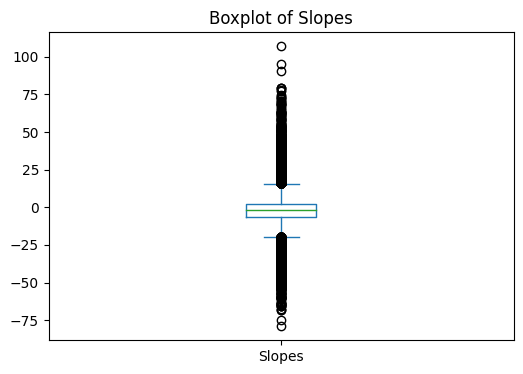

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame(df_final)
# Select the column you want to analyze
selected_column = 'Slopes'

# Calculate z-scores for the selected column
z_scores = np.abs((df[selected_column] - df[selected_column].mean()) / df[selected_column].std())

# Set a threshold for outlier detection (e.g., z-score greater than 3)
outlier_threshold = 3

# Detect outliers
outliers = df[z_scores > outlier_threshold]

# Visualize outliers using a box plot
plt.figure(figsize=(6, 4))
df[selected_column].plot.box()
plt.title(f"Boxplot of {selected_column}")
plt.show()


# 📁 **DataBTW**
> **Data between each valid TimeDiff**
```
Xtime = How many year pass since patient first visit
```

In [77]:
savedDataBTW[1835503]

{Timestamp('2018-09-28 12:44:59.257000'): {'PatientVisitUID': 5597886,
  'Xtime': [0.21095890410958903],
  'YeGFR': ['53.80']},
 Timestamp('2021-02-03 11:03:45.210000'): {'PatientVisitUID': 8102805,
  'Xtime': [2.5643835616438357],
  'YeGFR': ['35.72']},
 Timestamp('2021-02-04 10:45:04.480000'): {'PatientVisitUID': 8106999,
  'Xtime': [2.5643835616438357],
  'YeGFR': ['40.54']}}

# ✨ **List dfBTW**

In [18]:
timeFrame = 365

# Create a collection (dict) to store data between each valid timeDiff
dfBTW = {}

# Loop through each patient group
for patientID, patient_df in df_sorted_reset.groupby('PatientUID'):
    validVisitID = [patient_df.iloc[0]['PatientVisitUID']]  # Initialize with the first visit
    visitBefore = patient_df.iloc[0]['datetime']

    # Create a nested dictionary to store information for this patient "id"
    dfBTW[patientID] = {}

    for index, row in patient_df.iterrows():
        visitNow = row['PatientVisitUID']
        timeVisitNow = row['datetime']

        if (timeVisitNow - visitBefore).days >= timeFrame:
            validVisitID.append(visitNow)
            visitBefore = timeVisitNow  # Update visitBefore with the current visitNow

        # Store eGFR value and time point value
        if visitBefore in dfBTW[patientID]:
            dfBTW[patientID][visitBefore]["eGFR"].append(row["ResultValue"])
            dfBTW[patientID][visitBefore]["timepoint"].append((timeVisitNow - visitBefore).days)
        else:
            dfBTW[patientID][visitBefore] = {
                "eGFR": [row["ResultValue"]],
                "timepoint": [(timeVisitNow - visitBefore).days]
            }

# Perform linear regression on each patient's data
for id, visits in dfBTW.items():
    for visit, data in visits.items():
        if len(data["eGFR"]) > 1:
            time_points = data["timepoint"]
            eGFR_values = data["eGFR"]
            # Perform linear regression using time_points as X and eGFR_values as y
            # You can use libraries like numpy and scipy for regression analysis here
            # The results of the linear regression can be stored in a suitable data structure
            # For example: regression_results = perform_linear_regression(time_points, eGFR_values)


In [19]:
dfBTW[2299] #len(set(dfBTW)) = 20967

{Timestamp('2016-08-15 09:51:54.913000'): {'eGFR': ['71.7',
   '66.8',
   '67.20',
   '69.20'],
  'timepoint': [0, 87, 228, 324]},
 Timestamp('2017-10-03 09:19:54.710000'): {'eGFR': ['63.60',
   '58.40',
   '62.40',
   '55.00',
   '64.00',
   '62.40'],
  'timepoint': [0, 92, 176, 260, 288, 343]},
 Timestamp('2018-12-12 09:18:49.913000'): {'eGFR': ['70.20',
   '73.50',
   '65.40',
   '61.90',
   '62.70'],
  'timepoint': [0, 90, 189, 280, 330]},
 Timestamp('2019-12-19 09:51:24.427000'): {'eGFR': ['64.02',
   '64.92',
   '58.37',
   '54.86',
   '59.12',
   '56.21',
   '61.48',
   '55.14'],
  'timepoint': [0, 34, 59, 83, 167, 251, 279, 350]},
 Timestamp('2021-03-04 10:01:42.113000'): {'eGFR': ['48.54',
   '55.14',
   '56.52',
   '60.62'],
  'timepoint': [0, 108, 227, 318]},
 Timestamp('2022-04-21 08:45:54.580000'): {'eGFR': ['80.47', '76.59', '79.14'],
  'timepoint': [0, 69, 196]}}

### 📈 **CalculateSlope**

In [20]:
time_points = np.array(time_points, dtype=np.float64)
eGFR_values = np.array(eGFR_values, dtype=np.float64)


In [21]:
import numpy as np
from scipy.stats import linregress

# Perform linear regression on each patient's data
for id, visits in dfBTW.items():
    for visit, data in visits.items():
        if len(data["eGFR"]) > 1:
            time_points = np.array(data["timepoint"], dtype=np.float64)
            eGFR_values = np.array(data["eGFR"])

            # Convert 'ND', 'CC', and '-' to NaN (Not a Number)
            non_numeric_values = ['ND', 'CC', '-','Not detected','nd','r']
            eGFR_values = np.where(np.isin(eGFR_values, non_numeric_values), np.nan, eGFR_values)

            # Convert the array to float after handling non-numeric values
            eGFR_values = eGFR_values.astype(np.float64)

            # Remove rows with NaN values
            valid_indices = ~np.isnan(eGFR_values)
            time_points = time_points[valid_indices]
            eGFR_values = eGFR_values[valid_indices]

            # Check for variability in time_points
            unique_time_points = np.unique(time_points)
            if unique_time_points.size > 1:
                # Perform linear regression using scipy.stats.linregress
                slope, intercept, r_value, p_value, std_err = linregress(time_points, eGFR_values)

                # Store the calculated slope and intercept in the dictionary
                dfBTW[id][visit]["slope"] = slope
                dfBTW[id][visit]["intercept"] = intercept
            else:
                # Handle cases where there's no variability in time_points
                print(f"No variability in time_points for {id} - {visit}")
                dfBTW[id][visit]["slope"] = None
                dfBTW[id][visit]["intercept"] = None


No variability in time_points for 154921 - 2019-11-18 21:14:08.523000
No variability in time_points for 163020 - 2022-07-23 09:37:25.827000
No variability in time_points for 168595 - 2022-07-17 22:26:20.390000
No variability in time_points for 220028 - 2020-10-09 11:31:17.580000
No variability in time_points for 315788 - 2022-12-01 13:46:40.723000
No variability in time_points for 319028 - 2020-07-07 18:59:13.957000
No variability in time_points for 330351 - 2021-07-19 10:59:39.703000
No variability in time_points for 359276 - 2022-09-26 21:03:51.793000
No variability in time_points for 394230 - 2019-01-18 00:42:40.960000
No variability in time_points for 769152 - 2022-10-17 14:31:58.527000
No variability in time_points for 789232 - 2019-11-04 16:05:34.630000
No variability in time_points for 847247 - 2022-01-04 18:43:10.223000
No variability in time_points for 888195 - 2023-01-27 11:11:55.743000
No variability in time_points for 1004900 - 2022-08-09 14:37:03.110000
No variability in t

In [22]:
dfBTW[1835503]

{Timestamp('2018-07-13 10:46:26.187000'): {'eGFR': ['49.40', '53.80'],
  'timepoint': [0, 77],
  'slope': 0.05714285714285713,
  'intercept': 49.39999999999999},
 Timestamp('2021-02-03 11:03:45.210000'): {'eGFR': ['35.72', '40.54'],
  'timepoint': [0, 0],
  'slope': None,
  'intercept': None}}

In [23]:
df_final[df_final['datetime']=='2021-02-03 11:03:45.210000']

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime
256713,1835503,8102805,2564-02-03 11:03:45.210,eGFR(CKD-EPI) age >=18,35.72,2021-02-03,2021-02-03 11:03:45.210


In [24]:
df_sorted_reset[df_sorted_reset['PatientUID']==1835503]

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime
256711,1835503,5363662,2561-07-13 10:46:26.187,eGFR(CKD-EPI) age >=18,49.40,2018-07-13,2018-07-13 10:46:26.187
256712,1835503,5597886,2561-09-28 12:44:59.257,eGFR(CKD-EPI) age >=18,53.80,2018-09-28,2018-09-28 12:44:59.257
256713,1835503,8102805,2564-02-03 11:03:45.210,eGFR(CKD-EPI) age >=18,35.72,2021-02-03,2021-02-03 11:03:45.210
256714,1835503,8106999,2564-02-04 10:45:04.480,eGFR(CKD-EPI) age >=18,40.54,2021-02-04,2021-02-04 10:45:04.480


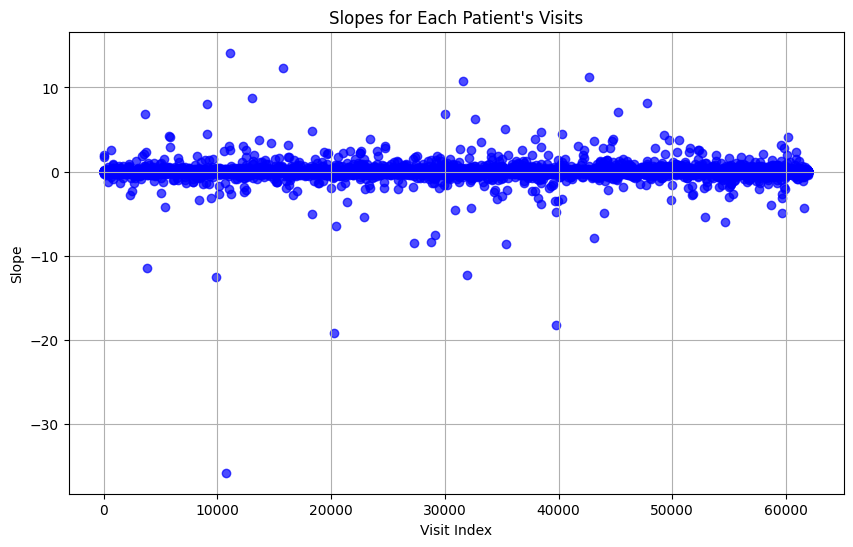

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# ... Your previous code ...

# Collect data for plotting
x_values = []  # Visit indices
y_values = []  # Slopes

# Perform linear regression on each patient's data
for id, visits in dfBTW.items():
    for visit, data in visits.items():
        if len(data["eGFR"]) > 1 and data["slope"] is not None:
            slope = data["slope"]
            x_values.append(len(y_values) + 1)  # Index of visit
            y_values.append(slope)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_values, y_values, color='blue', alpha=0.7)
plt.title("Slopes for Each Patient's Visits")
plt.xlabel("Visit Index")
plt.ylabel("Slope")
plt.grid(True)
plt.show()


In [26]:
import pandas as pd

# Create a list of DataFrames
dfs = []

# Iterate through dfBTW and create a DataFrame for each patient
for patient_id, visits in dfBTW.items():
    df_patient = pd.DataFrame.from_dict(visits, orient='index')
    df_patient['PatientID'] = patient_id
    dfs.append(df_patient)

# Concatenate the list of DataFrames into a single DataFrame
dfBTW_df = pd.concat(dfs)


In [27]:
dfBTW_df

,eGFR,timepoint,slope,intercept,PatientID
2016-08-15 09:51:54.913,"[71.7, 66.8, 67.20, 69.20]","[0, 87, 228, 324]",-0.005785,69.649177,2299
2017-10-03 09:19:54.710,"[63.60, 58.40, 62.40, 55.00, 64.00, 62.40]","[0, 92, 176, 260, 288, 343]",-0.002029,61.358676,2299
2018-12-12 09:18:49.913,"[70.20, 73.50, 65.40, 61.90, 62.70]","[0, 90, 189, 280, 330]",-0.031938,72.418508,2299
2019-12-19 09:51:24.427,"[64.02, 64.92, 58.37, 54.86, 59.12, 56.21, 61....","[0, 34, 59, 83, 167, 251, 279, 350]",-0.015916,61.698168,2299
2021-03-04 10:01:42.113,"[48.54, 55.14, 56.52, 60.62]","[0, 108, 227, 318]",0.034886,49.509809,2299
...,...,...,...,...,...
2022-12-14 11:30:53.310,"[47.44, 49.07]","[0, 90]",0.018111,47.440000,3421578
2022-11-29 10:47:37.917,"[27.88, 27.69]","[0, 100]",-0.001900,27.880000,3426284
2022-12-13 13:42:48.510,"[54.65, 44.30]","[0, 104]",-0.099519,54.650000,3431501
2022-12-15 09:48:31.117,"[70.18, 48.51, 67.71, 72.86, 68.69, 45.08]","[0, 25, 43, 46, 71, 116]",-0.141678,69.279199,3432056


#### 📍 **check**

> **np.isinf**




In [90]:
import numpy as np
import pandas as pd

# Assuming you have already calculated 'Slope' as shown in previous steps

# Find rows with infinite 'Slope' values
inf_rows = df_final[np.isinf(df_final['Slopes'])]
inf_indices = inf_rows.index

# Find rows immediately before the rows with infinite 'Slope' values
rows_before_inf = df_final[np.isinf(df_final['Slopes'].shift(-1))]

# Concatenate both DataFrames to get rows before and after 'inf_rows'
result = pd.concat([rows_before_inf, inf_rows])

# Print the resulting DataFrame
result

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes


In [91]:
dfBTW_df[dfBTW_df['slope'].isnull()] #cuz timepoint == 0

,eGFR,timepoint,slope,intercept,PatientID
2023-03-21 09:14:13.677,[48.90],[0],NaN,NaN,2362
2017-10-02 09:07:27.390,[46.00],[0],NaN,NaN,2378
2020-01-15 09:27:49.527,[42.66],[0],NaN,NaN,2625
2019-10-08 23:11:21.057,[58.60],[0],NaN,NaN,2930
2023-04-07 07:41:59.960,[48.85],[0],NaN,NaN,3075
...,...,...,...,...,...
2023-04-04 08:28:58.833,[33.68],[0],NaN,NaN,3319961
2023-04-04 08:49:20.047,[26.47],[0],NaN,NaN,3319971
2023-04-10 08:36:15.217,[70.36],[0],NaN,NaN,3320048
2023-04-10 08:58:57.267,[30.69],[0],NaN,NaN,3320050


In [93]:
df_final.isnull().any()

PatientUID         False
PatientVisitUID    False
CWhen              False
ResultItemName     False
ResultValue         True
date               False
datetime           False
TimeDiff            True
Slopes              True
dtype: bool

In [95]:
df_final[df_final['ResultValue'].isnull()] ## 4 rows >> ND/CC

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
213204,1269185,6082408,2562-03-13 09:40:29.180,eGFR(CKD-EPI) age >=18,NaN,2019-03-13,2019-03-13 09:40:29.180,NaN,NaN
235419,1480125,3615923,2559-11-02 10:43:49.273,eGFR(CKD-EPI) age >=18,NaN,2016-11-02,2016-11-02 10:43:49.273,NaN,NaN
240744,1523723,7139521,2564-01-06 14:54:19.083,eGFR(CKD-EPI) age >=18,NaN,2021-01-06,2021-01-06 14:54:19.083,1.912329,NaN
289352,2587904,5828463,2561-12-17 18:16:25.357,eGFR(CKD-EPI) age >=18,NaN,2018-12-17,2018-12-17 18:16:25.357,1.030137,NaN


In [97]:
df_final[df_final['TimeDiff'].isnull()] ## 20967 rows >> first Visit of each patient

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
0,2299,3386255,2559-08-15 09:51:54.913,eGFR(CKD-EPI) age >=18,71.70,2016-08-15,2016-08-15 09:51:54.913,NaN,NaN
30,2304,3431160,2559-08-30 09:37:00.867,eGFR(CKD-EPI) age >=18,68.90,2016-08-30,2016-08-30 09:37:00.867,NaN,NaN
45,2312,5136829,2561-04-28 14:39:32.587,eGFR(CKD-EPI) age >=18,57.60,2018-04-28,2018-04-28 14:39:32.587,NaN,NaN
65,2354,7003273,2563-01-09 07:57:21.190,eGFR(CKD-EPI) age >=18,56.99,2020-01-09,2020-01-09 07:57:21.190,NaN,NaN
78,2362,3910608,2560-02-20 19:48:50.243,eGFR(CKD-EPI) age >=18,67.60,2017-02-20,2017-02-20 19:48:50.243,NaN,NaN
...,...,...,...,...,...,...,...,...,...
318672,3421578,10151787,2565-12-14 11:30:53.310,eGFR(CKD-EPI) age >=18,47.44,2022-12-14,2022-12-14 11:30:53.310,NaN,NaN
318674,3426284,10105952,2565-11-29 10:47:37.917,eGFR(CKD-EPI) age >=18,27.88,2022-11-29,2022-11-29 10:47:37.917,NaN,NaN
318676,3431501,10144649,2565-12-13 13:42:48.510,eGFR(CKD-EPI) age >=18,54.65,2022-12-13,2022-12-13 13:42:48.510,NaN,NaN
318678,3432056,10154545,2565-12-15 09:48:31.117,eGFR(CKD-EPI) age >=18,70.18,2022-12-15,2022-12-15 09:48:31.117,NaN,NaN


In [101]:
df = pd.DataFrame(df_final)
result = df.dropna()
result

,PatientUID,PatientVisitUID,CWhen,ResultItemName,ResultValue,date,datetime,TimeDiff,Slopes
4,2299,4546471,2560-10-03 09:19:54.710,eGFR(CKD-EPI) age >=18,63.60,2017-10-03,2017-10-03 09:19:54.710,1.131507,-7.158596
10,2299,5812902,2561-12-12 09:18:49.913,eGFR(CKD-EPI) age >=18,70.20,2018-12-12,2018-12-12 09:18:49.913,1.189041,5.550691
15,2299,6947220,2562-12-19 09:51:24.427,eGFR(CKD-EPI) age >=18,64.02,2019-12-19,2019-12-19 09:51:24.427,1.019178,-6.063710
23,2299,8186767,2564-03-04 10:01:42.113,eGFR(CKD-EPI) age >=18,48.54,2021-03-04,2021-03-04 10:01:42.113,1.208219,-12.812245
27,2299,9385133,2565-04-21 08:45:54.580,eGFR(CKD-EPI) age >=18,80.47,2022-04-21,2022-04-21 08:45:54.580,1.128767,28.287500
...,...,...,...,...,...,...,...,...,...
317522,3319961,10553903,2566-04-04 08:28:58.833,eGFR(CKD-EPI) age >=18,33.68,2023-04-04,2023-04-04 08:28:58.833,1.054795,-4.256753
317529,3319971,10553916,2566-04-04 08:49:20.047,eGFR(CKD-EPI) age >=18,26.47,2023-04-04,2023-04-04 08:49:20.047,1.054795,-0.692078
317540,3320048,10572126,2566-04-10 08:36:15.217,eGFR(CKD-EPI) age >=18,70.36,2023-04-10,2023-04-10 08:36:15.217,1.095890,7.217875
317556,3320050,10572565,2566-04-10 08:58:57.267,eGFR(CKD-EPI) age >=18,30.69,2023-04-10,2023-04-10 08:58:57.267,1.082192,-32.794557


In [ ]:
# Save DataFrame to Excel file
#dfBTW_df.to_excel('SlopeBTW.xlsx', index=True)

In [ ]:
#df.to_excel('slope(keep null).xlsx')

In [ ]:
#result.to_excel('slope.xlsx')